In [1]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from IPython.core.debugger import set_trace

In [2]:
df_absorp = pd.read_csv('../Data/tecator_absorp.csv')
df_endpoints = pd.read_csv('../Data/tecator_endpoints.csv')

In [3]:
df_absorp.drop(columns='Unnamed: 0', inplace=True)
df_endpoints.drop(columns='Unnamed: 0', inplace=True)
df_endpoints.rename(columns={'V1': 'Moisture', 'V2': 'Fat', 'V3': 'Protein'}, inplace=True)

In [4]:
df_absorp

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,3.00247,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.30473,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.70934,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.99820,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.32201,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3.14626,3.15166,3.15703,3.16244,3.16791,3.17348,3.17923,3.18521,3.19140,3.19792,...,3.63298,3.61483,3.59695,3.57915,3.56142,3.54365,3.52563,3.50705,3.48765,3.46769
211,2.57992,2.58040,2.58099,2.58175,2.58266,2.58381,2.58530,2.58719,2.58949,2.59225,...,2.97211,2.95464,2.93756,2.92062,2.90367,2.88668,2.86951,2.85180,2.83347,2.81473
212,2.56875,2.56923,2.56985,2.57060,2.57150,2.57268,2.57420,2.57610,2.57841,2.58129,...,2.96551,2.94870,2.93226,2.91592,2.89952,2.88291,2.86595,2.84836,2.82998,2.81111
213,2.65884,2.65943,2.66023,2.66108,2.66215,2.66360,2.66550,2.66787,2.67070,2.67405,...,3.06390,3.04851,3.03351,3.01851,3.00327,2.98759,2.97121,2.95374,2.93514,2.91564


In [5]:
df_endpoints

,Moisture,Fat,Protein
0,60.5,22.5,16.7
1,46.0,40.1,13.5
2,71.0,8.4,20.5
3,72.8,5.9,20.7
4,58.3,25.5,15.5
...,...,...,...
210,53.4,31.3,15.3
211,51.6,33.8,13.8
212,50.3,35.5,13.2
213,44.9,42.5,12.0


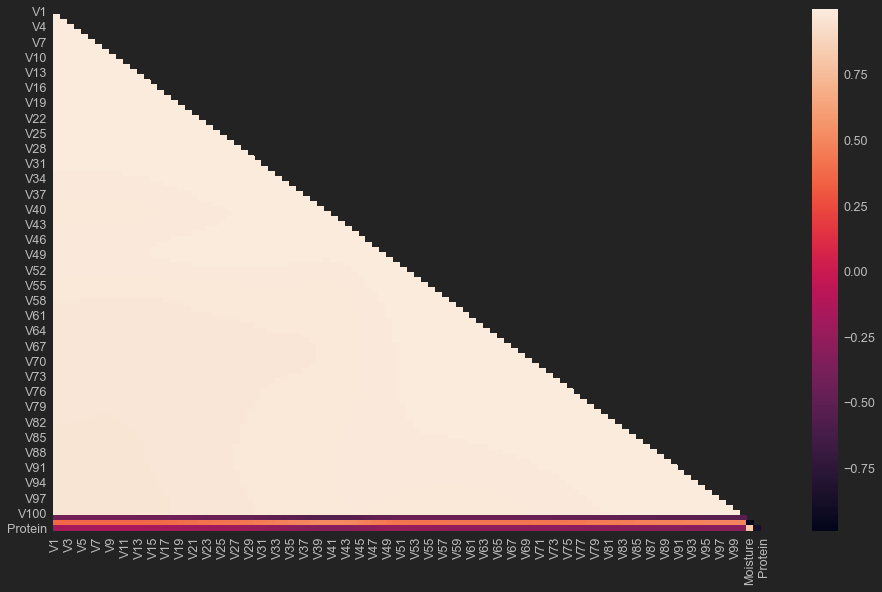

In [6]:
corr = pd.concat((df_absorp, df_endpoints), axis=1, join='inner').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask);

# b)

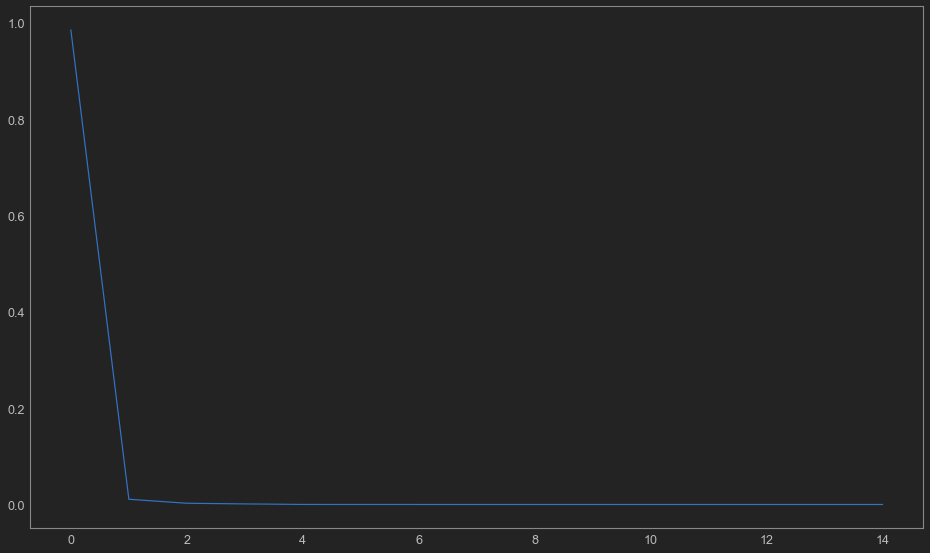

In [7]:
pt = PowerTransformer(method='box-cox')
df_absorp_box_coxed = pt.fit_transform(df_absorp)
pca = PCA(n_components=15)
pca_components = pca.fit_transform(df_absorp_box_coxed)
plt.plot(np.arange(pca.n_components_), pca.explained_variance_ratio_, label='Explained variance by components');

In [8]:
pca.explained_variance_ratio_[:5]

array([9.85269997e-01, 1.08484488e-02, 2.54787340e-03, 1.19489123e-03,
       8.87738998e-05])

## Using PCA the effective dimension would consist of 1, maybe 2, components.

# c)
### The scatter plots below show, that there is high heteroscedasticity in the data. I want to try and see if the results would be better with that issue resolved.

### Data preparation

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(df_absorp, df_endpoints)
# The power transformer also applies standarization by default.
box_cox = PowerTransformer(method='box-cox', standardize=True)
X_train = box_cox.fit_transform(X_train)
X_test = box_cox.transform(X_test)

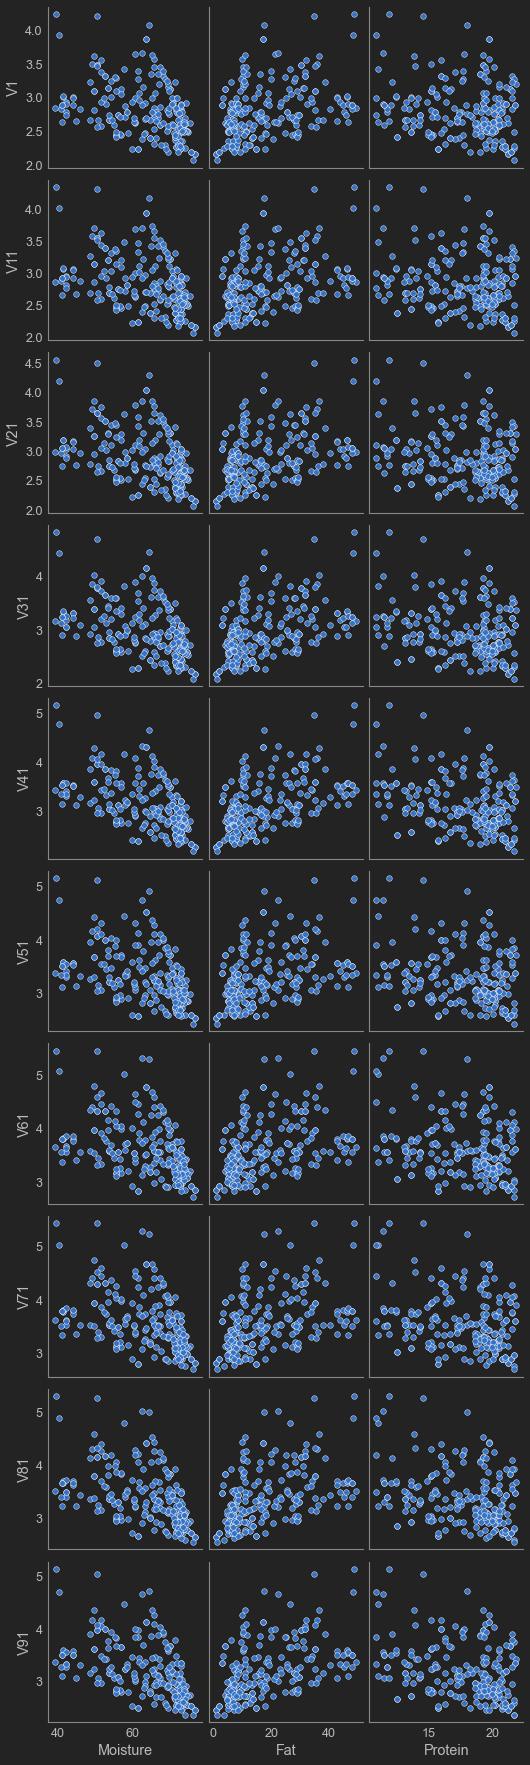

In [12]:
absorp_reduced = df_absorp.iloc[:, ::10]
sns.pairplot(pd.concat((absorp_reduced, df_endpoints), axis=1), x_vars=df_endpoints.columns.values, 
             y_vars=absorp_reduced.columns.values);

In [40]:
def score_model(model, X, Y):
    predictions = model.predict(X)
    return r2_score(y_true=Y, y_pred=predictions), np.sqrt(mean_squared_error(y_true=Y, y_pred=predictions))

def print_score(model_name, parameter_name, parameter_values, rmses, r2s):
    rmse_best_idx = rmses.argmin()
    rmse_best_value = rmses[rmse_best_idx]
    r2_best_idx = r2s.argmax()
    r2_best_value = r2s[r2_best_idx]
    print(f'{model_name} acheives the optimal result for {parameter_name} = {parameter_values[rmse_best_idx]} with \n'
          f'RMSE = {rmse_best_value}\n'
          f'R-Squared = {r2_best_value}')

def plot_r2_rmse(r2s, rmses, x_label, x_vals):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(x_vals, r2s)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('R^2')
    ax2.plot(x_vals, rmses)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('RMSE');

## Ordinary least squares regression

In [41]:
def do_ols(X_train, X_test, Y_train, Y_test):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, Y_train)
    r2, rmse = score_model(linear_regression, X_test, Y_test)
    print(f'R^2 = {r2}\n'
          f'RMSE = {rmse}')

do_ols(X_train, X_test, Y_train, Y_test)

R^2 = 0.9170481246295518
RMSE = 1.984935003301765


## Principal component regression

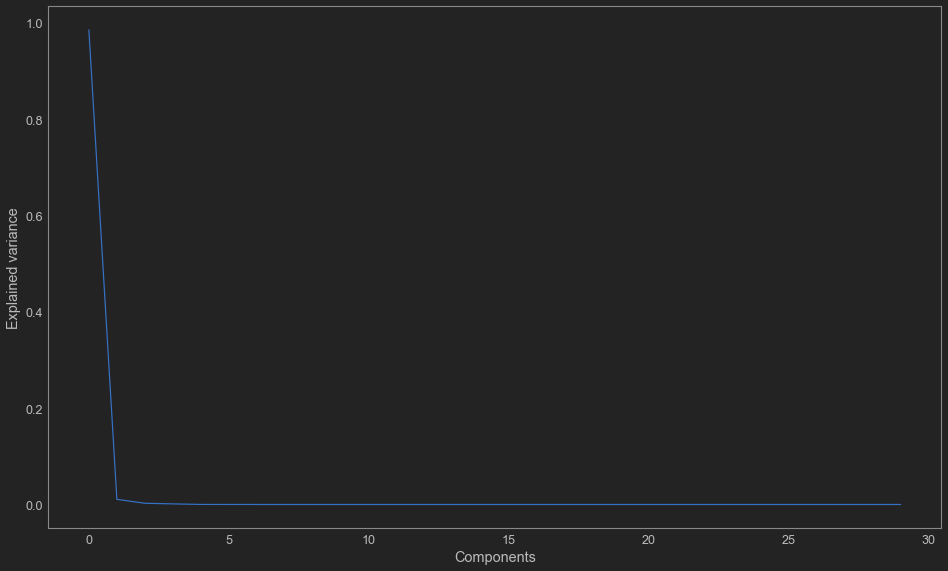

In [45]:
pca_r = PCA(30)
X_train_pca = pca_r.fit_transform(X_train)
X_test_pca = pca_r.transform(X_test)

plt.plot(np.arange(pca_r.n_components_), pca_r.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Explained variance');

PCR acheives the optimal result for number of components = 21 with 
RMSE = 1.3872622227165263
R-Squared = 0.9667231456151596


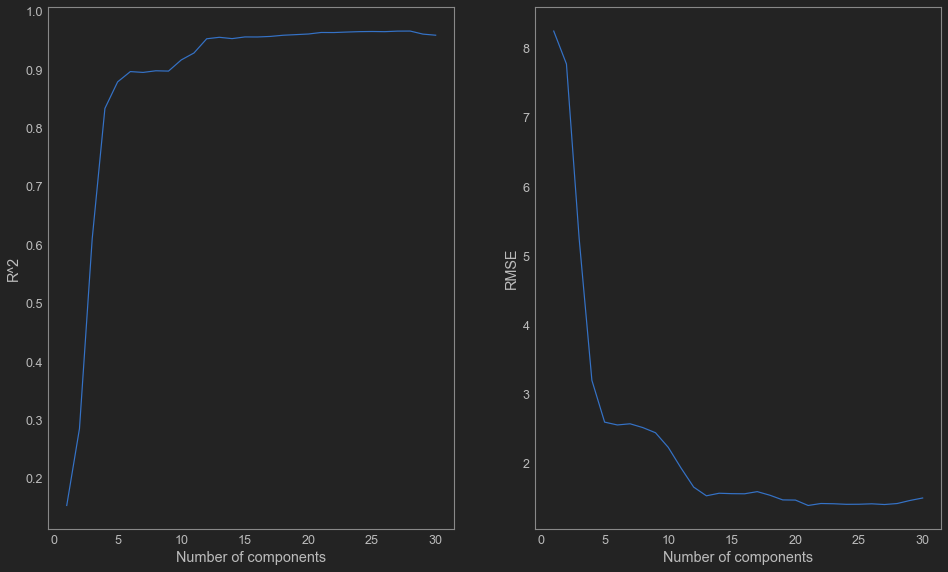

In [46]:
def do_pcr(X_train, X_test, Y_train, Y_test):
    n_cols = X_train_pca.shape[1]
    chosen_components = np.arange(1, n_cols + 1)
    r2s_pcr = np.empty(n_cols)
    rmses_pcr = np.empty(n_cols)
    for i in chosen_components:
        model = LinearRegression()
        model.fit(X_train[:, :i], Y_train)
        r2s_pcr[i - 1], rmses_pcr[i - 1] = score_model(model, X_test[:, :i], Y_test)

    plot_r2_rmse(r2s=r2s_pcr, rmses=rmses_pcr, x_label='Number of components', x_vals=range(1, n_cols + 1))
    print_score(model_name='PCR', parameter_name='number of components', parameter_values=chosen_components,
                rmses=rmses_pcr, r2s=r2s_pcr)

do_pcr(X_train_pca, X_test_pca, Y_train, Y_test)

## Partial least squares regression

PLSR acheives the optimal result for number of components = 17 with 
RMSE = 1.401136823900384
R-Squared = 0.9640806820653305


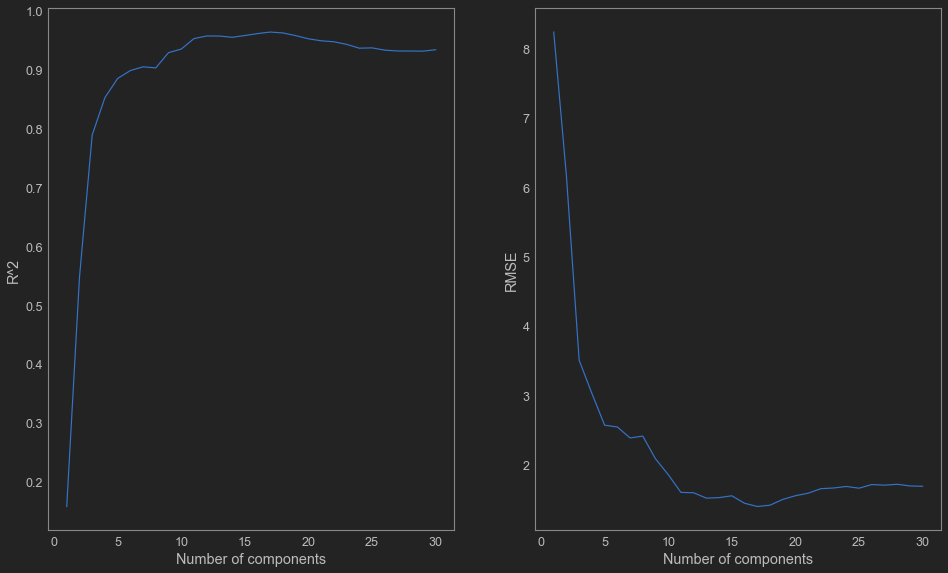

In [47]:
def do_pls(X_train, X_test, Y_train, Y_test):
    n_components = 30
    chosen_components = np.arange(1, n_components + 1)
    r2s_pls = np.empty(n_components)
    rmses_pls = np.empty(n_components)

    for i in chosen_components:
        model = PLSRegression(n_components=i)
        model.fit(X_train, Y_train)
        r2s_pls[i - 1], rmses_pls[i - 1] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_pls, rmses=rmses_pls, x_label='Number of components', x_vals=chosen_components)
    print_score(model_name='PLSR', parameter_name='number of components', parameter_values=chosen_components,
                rmses=rmses_pls, r2s=r2s_pls)

do_pls(X_train, X_test, Y_train, Y_test)

## Ridge

Ridge acheives the optimal result for alpha = 4.0816326530612245e-05 with 
RMSE = 1.4423511388472514
R-Squared = 0.9621020885049516


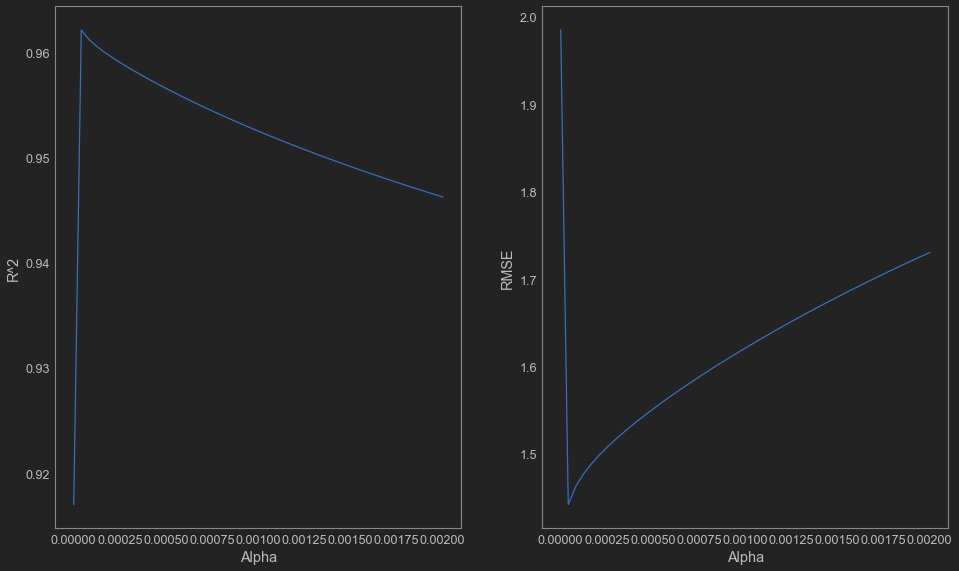

In [48]:
def do_ridge(X_train, X_test, Y_train, Y_test):
    alphas = np.linspace(0, 0.002, 50)
    r2s_ridge = np.empty(alphas.size)
    rmses_ridge = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = Ridge(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_ridge[i], rmses_ridge[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_ridge, rmses=rmses_ridge, x_label='Alpha', x_vals=alphas)
    print_score(model_name='Ridge', parameter_name='alpha', parameter_values=alphas, rmses=rmses_ridge, r2s=r2s_ridge)
    
do_ridge(X_train, X_test, Y_train, Y_test)

## Lasso

<ipython-input-61-2a95cba0d1af>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, Y_train)
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.1434030447062, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.3933649074468,

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2547.9637449756565, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.012239704411456, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.51972615030354, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.871935879181706, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.2761269887469, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.66677249120494, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pa

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.38574949635813, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3482354143700377, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.06587930376554, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.21189069721004, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.42291904468084, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.391233779566619, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-p

Lasso acheives the optimal result for alpha = 0.05714285714285715 with 
RMSE = 2.523351313478576
R-Squared = 0.8802522468759175


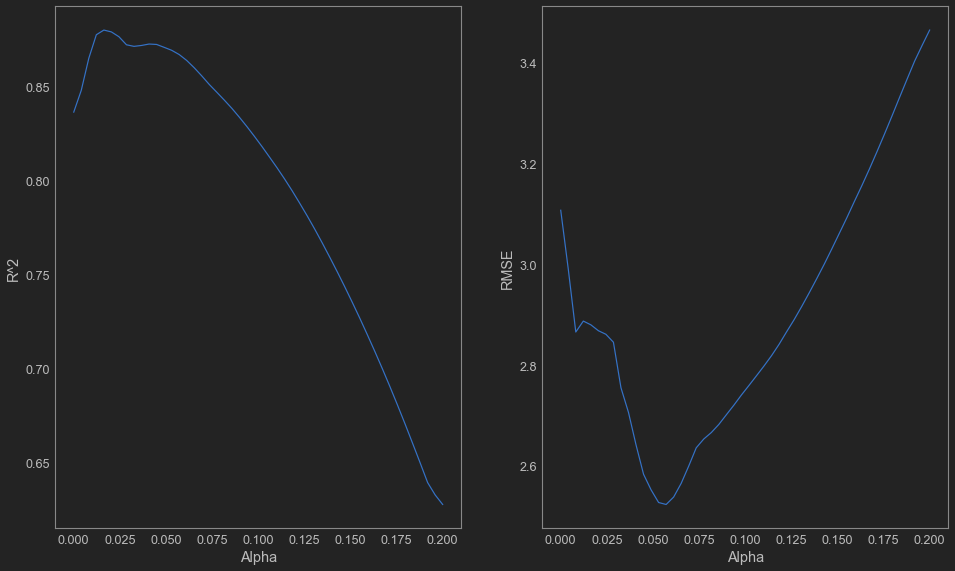

In [61]:
def do_lasso(X_train, X_test, Y_train, Y_test, alpha_min, alpha_max):
    alphas = np.linspace(alpha_min, alpha_max, 50)
    r2s_lasso = np.empty(alphas.size)
    rmses_lasso = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = Lasso(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_lasso[i], rmses_lasso[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_lasso, rmses=rmses_lasso, x_label='Alpha', x_vals=alphas)
    print_score(model_name='Lasso', parameter_name='alpha', parameter_values=alphas, rmses=rmses_lasso, r2s=r2s_lasso)

do_lasso(X_train, X_test, Y_train, Y_test, 0.0, 0.2)

## ElasticNet

<ipython-input-66-ccdd66ccec16>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, Y_train)
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.1434030447062, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.3933649074468,

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2568.4104725069656, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265.92930885414773, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1358.961254566325, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-p

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2498.476971868219, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.42648613725362, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1250.1127312381955, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-p

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.90270407765797, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1090.4829449525294, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2247.5251488658055, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-p

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.346269404873965, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943.5227003530658, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025.6398634247066, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-p

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.66962296609887, tolerance: 0.14809426086956523
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 910.4671314816803, tolerance: 1.6108712049689442
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2035.6448208033726, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pa

ElasticNet acheives the optimal result for alpha = 0.018367346938775512 with 
RMSE = 2.5140720480461947
R-Squared = 0.8957469934106387


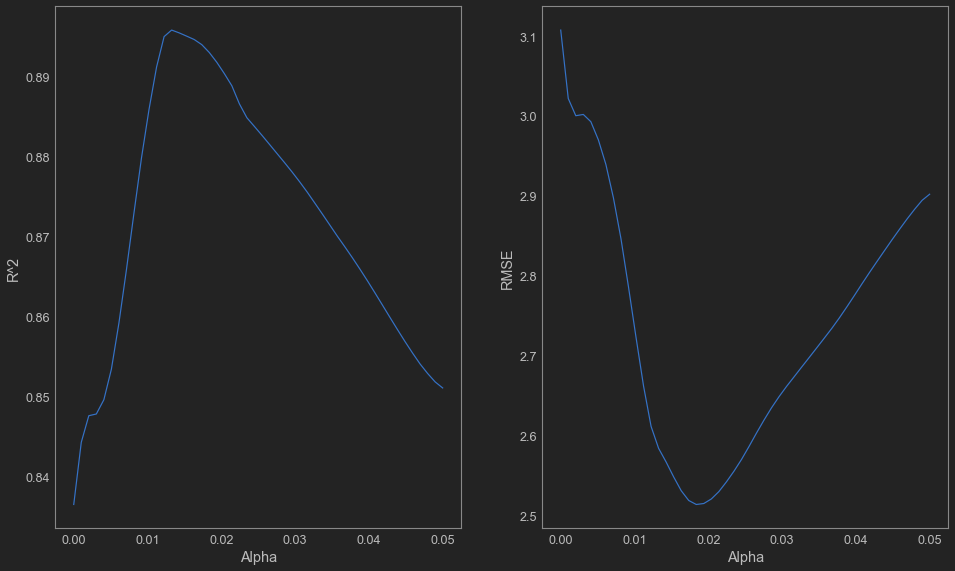

In [66]:
def do_elastic_net(X_train, X_test, Y_train, Y_test, alpha_min, alpha_max):
    alphas = np.linspace(alpha_min, alpha_max, 50)
    r2s_elastic = np.empty(alphas.size)
    rmses_elastic = np.empty(alphas.size)
    for i, alpha in enumerate(alphas):
        model = ElasticNet(alpha=alpha)
        model.fit(X_train, Y_train)
        r2s_elastic[i], rmses_elastic[i] = score_model(model, X_test, Y_test)

    plot_r2_rmse(r2s=r2s_elastic, rmses=rmses_elastic, x_label='Alpha', x_vals=alphas)
    print_score(model_name='ElasticNet', parameter_name='alpha', parameter_values=alphas, rmses=rmses_elastic,
                r2s=r2s_elastic)

do_elastic_net(X_train, X_test, Y_train, Y_test, 0.0, 0.05)

## d)
### The best result is achieved by ridge regression with PCR and PLSR following close behind. PLSR is slightly better than PCR, but the difference is extremely small. Lasso and ElasticNet have significantly worse results and OLS is the worst.

## e)

In [55]:
Y_train_fat = Y_train['Fat']
Y_test_fat = Y_test['Fat']

In [56]:
do_ols(X_train, X_test, Y_train_fat, Y_test_fat)

R^2 = 0.9626259822922001
RMSE = 2.378813356107176


PCR acheives the optimal result for number of components = 21 with 
RMSE = 1.7566990086945442
R-Squared = 0.9796181424000266


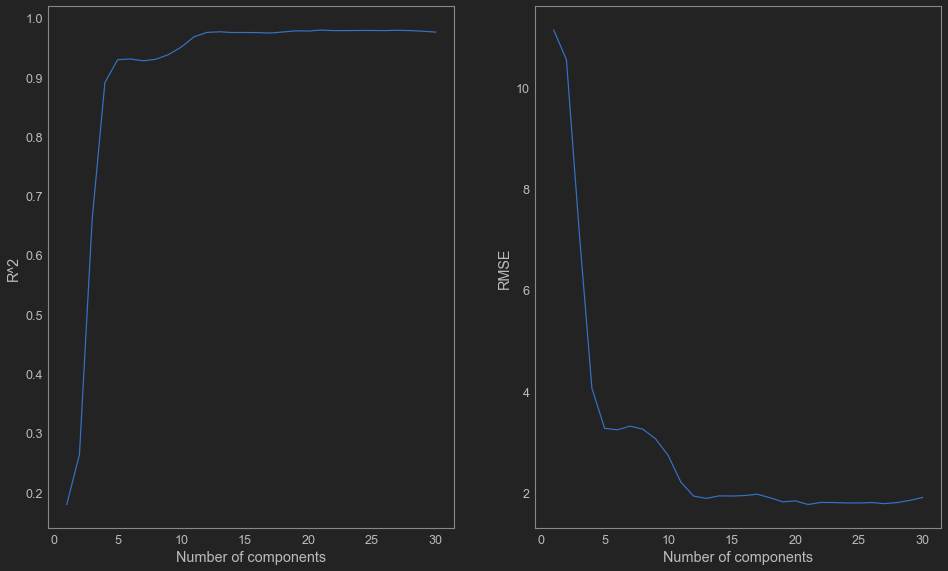

In [57]:
do_pcr(X_train_pca, X_test_pca, Y_train_fat, Y_test_fat)

PLSR acheives the optimal result for number of components = 15 with 
RMSE = 1.7867868576486832
R-Squared = 0.9789139831387244


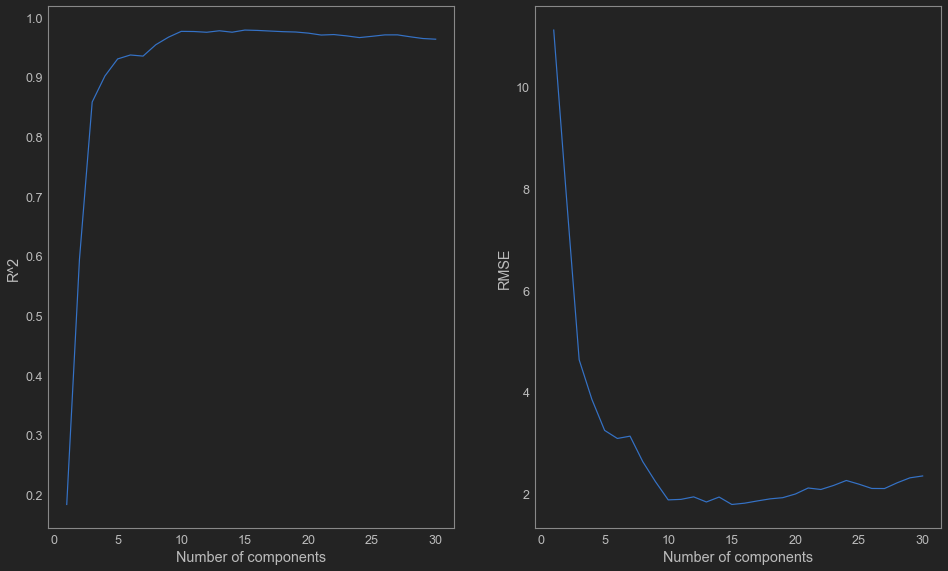

In [58]:
do_pls(X_train, X_test, Y_train_fat, Y_test_fat)

Ridge acheives the optimal result for alpha = 4.0816326530612245e-05 with 
RMSE = 1.7849686238468363
R-Squared = 0.9789568755535691


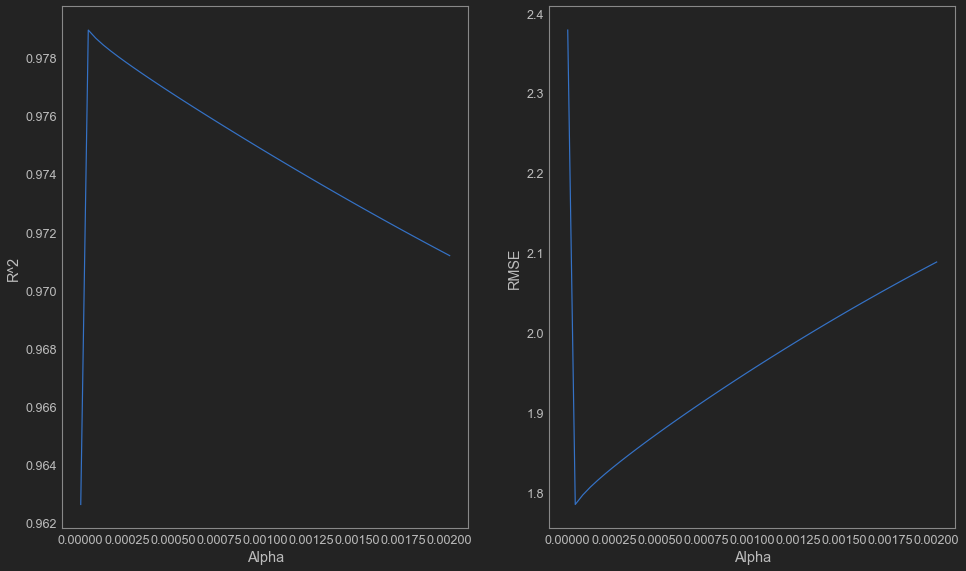

In [59]:
do_ridge(X_train, X_test, Y_train_fat, Y_test_fat)

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1738.0680334040267, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1839.9015501267968, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1926.032637815078, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pa

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.4909004790593, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 684.6505887536591, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.1888484594674, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pack

Lasso acheives the optimal result for alpha = 0.057346938775510205 with 
RMSE = 3.04204984744953
R-Squared = 0.9388802311730913


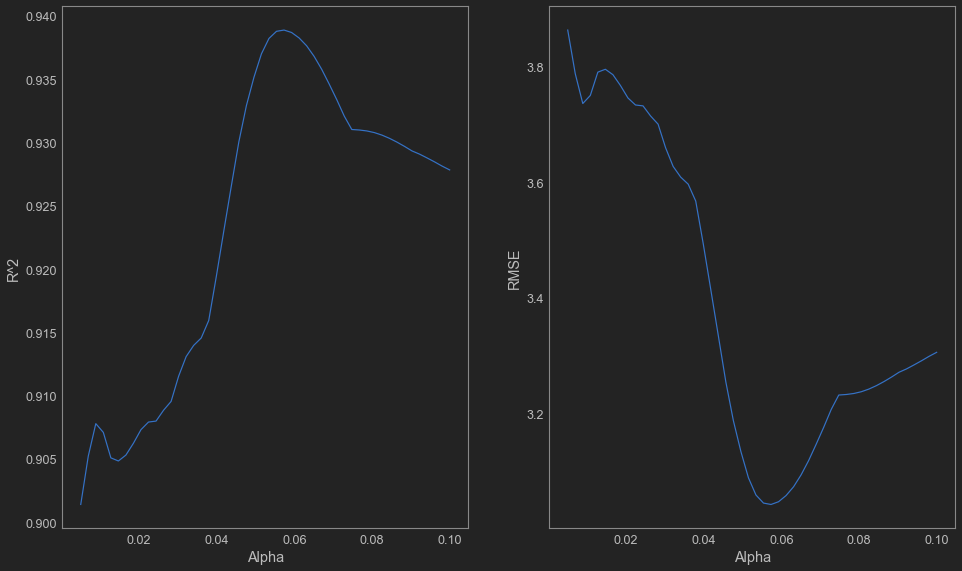

In [63]:
do_lasso(X_train, X_test, Y_train_fat, Y_test_fat, alpha_min=0.005, alpha_max=0.1)

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2549.436994900306, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2542.1682781972368, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2536.25721704012, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pack

C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025.9489768782503, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2026.221780859266, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2028.408462433486, tolerance: 2.6552871180124225
  model = cd_fast.enet_coordinate_descent(
C:\Users\mikko\anaconda3\envs\all_purpose\lib\site-pac

ElasticNet acheives the optimal result for alpha = 0.01979591836734694 with 
RMSE = 3.1413475773040767
R-Squared = 0.93482500079946


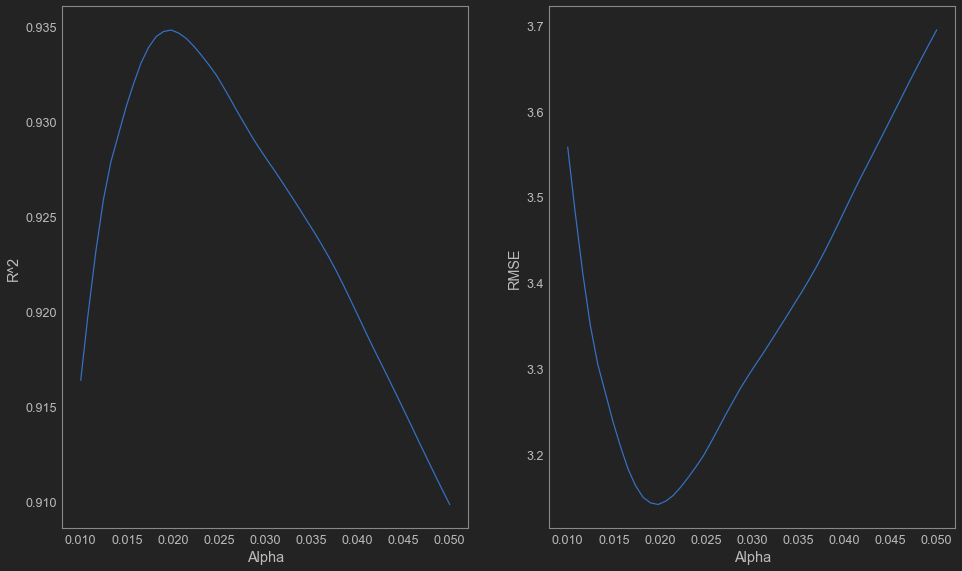

In [67]:
do_elastic_net(X_train, X_test, Y_train_fat, Y_test_fat, alpha_min=0.01, alpha_max=0.05)

### Here PCR, PLSR and Rigde come out with almost identical results. Of the three of them PCR comes out on top.